In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from interstellar import Tracks, DenseNetwork, set_seed
import os

In [2]:
seed = 101
name = 'network_07'
tracks = 'tracks_04b'
save_path = f'/home/ADF/ajl573/Data/interstellar_data/{name}'
load_path = f'/home/ADF/ajl573/Data/interstellar_data/{tracks}'

In [3]:
if not os.path.exists(save_path):
    os.mkdir(save_path)

In [4]:
train = pd.read_csv(f'{load_path}/{tracks}_train.csv')

## Resample

Let's try to resample 80% of the dataset

In [5]:
0.8 * len(train)

6188586.4

For simplicity and batching, I will round this down to 6 million points.

In [6]:
t = Tracks(name=tracks)
t.set_data(train.sample(n=6000000, weights='gradient', random_state=seed))

del train

In [7]:
t.get_data().head()

,evol_stage,initial_mass,initial_Yinit,initial_feh,initial_MLT,frac_age,effective_T,luminosity,log_g,surface_he4,surface_Z,star_feh,delta_nu_fit,initial_Zinit,gradient,log_star_age,log_radius
3995955,2,1.08,0.30,0.35,1.9,1.043595,5673.275,1.826398,4.178337,0.259003,0.024350,0.273529,86.067856,0.027260,0.000320,0.870810,0.146389
4415608,2,1.20,0.26,0.25,1.9,1.155536,5632.717,2.945005,4.003852,0.226761,0.020889,0.185828,62.464220,0.023076,0.001583,0.843099,0.256366
219821,2,0.94,0.26,0.25,2.3,1.260279,4816.204,2.492565,3.697376,0.255329,0.022432,0.235659,38.246070,0.023076,0.000526,1.276368,0.356172
1326105,2,0.97,0.24,0.25,2.3,1.184105,5254.683,1.341456,4.131911,0.210687,0.021564,0.190855,81.709206,0.023699,0.001516,1.268245,0.145954
5302363,2,0.80,0.24,-0.10,2.3,1.186145,4891.288,2.689784,3.620810,0.232189,0.010325,-0.121725,34.789745,0.010772,0.000489,1.412521,0.359271


In [8]:
len(t._data)

6000000

## Normalize

Let's choose the inputs and outputs and the normalise

In [9]:
x_cols = ['frac_age', 'initial_mass', 'initial_MLT', 'initial_Yinit', 'initial_Zinit']
y_cols = ['log_star_age', 'effective_T', 'log_radius', 'delta_nu_fit', 'star_feh']

In [10]:
factors, _df = t.normalize(loc='mean', scale='std', columns=x_cols+y_cols)

In [11]:
factors

,column,norm_column,loc,scale
0,frac_age,frac_age_norm,0.886590,0.402850
1,initial_mass,initial_mass_norm,0.996833,0.119499
2,initial_MLT,initial_MLT_norm,1.997272,0.338006
3,initial_Yinit,initial_Yinit_norm,0.280062,0.028064
4,initial_Zinit,initial_Zinit_norm,0.018318,0.010699
5,log_star_age,log_star_age_norm,0.784033,0.450751
6,effective_T,effective_T_norm,5528.783927,605.919601
7,log_radius,log_radius_norm,0.142940,0.149972
8,delta_nu_fit,delta_nu_fit_norm,92.475003,42.530333
9,star_feh,star_feh_norm,-0.017718,0.357204


Round the loc and scale to 3 dp

In [12]:
factors = round(factors, 3)

In [13]:
factors

,column,norm_column,loc,scale
0,frac_age,frac_age_norm,0.887,0.403
1,initial_mass,initial_mass_norm,0.997,0.119
2,initial_MLT,initial_MLT_norm,1.997,0.338
3,initial_Yinit,initial_Yinit_norm,0.280,0.028
4,initial_Zinit,initial_Zinit_norm,0.018,0.011
5,log_star_age,log_star_age_norm,0.784,0.451
6,effective_T,effective_T_norm,5528.784,605.920
7,log_radius,log_radius_norm,0.143,0.150
8,delta_nu_fit,delta_nu_fit_norm,92.475,42.530
9,star_feh,star_feh_norm,-0.018,0.357


In [14]:
factors, _df = t.normalize(loc=factors['loc'].to_numpy(), scale=factors['scale'].to_numpy(),
                           columns=x_cols+y_cols)
_df.head()

,frac_age_norm,initial_mass_norm,initial_MLT_norm,initial_Yinit_norm,initial_Zinit_norm,log_star_age_norm,effective_T_norm,log_radius_norm,delta_nu_fit_norm,star_feh_norm
3995955,0.388573,0.697479,-0.286982,0.714286,0.841818,0.192484,0.238465,0.022593,-0.150650,0.816607
4415608,0.666342,1.705882,-0.286982,-0.714286,0.461413,0.131040,0.171529,0.755774,-0.705638,0.570948
219821,0.926252,-0.478992,0.896450,-0.714286,0.461413,1.091725,-1.176030,1.421149,-1.275075,0.710530
1326105,0.737234,-0.226891,0.896450,-1.428571,0.518110,1.073714,-0.452372,0.019693,-0.253134,0.585029
5302363,0.742295,-1.655462,0.896450,-1.428571,-0.657099,1.393617,-1.052112,1.441808,-1.356343,-0.290547


In [15]:
del _df

In [16]:
t.normalize(loc=factors['loc'].to_numpy(), scale=factors['scale'].to_numpy(),
                           columns=x_cols+y_cols, inplace=True)

In [17]:
factors.to_csv(os.path.join(save_path, 'tracks_04b_norm.csv'), index=False)

In [18]:
train = t.get_data([f'{col}_norm' for col in x_cols+y_cols])
train.head()

,frac_age_norm,initial_mass_norm,initial_MLT_norm,initial_Yinit_norm,initial_Zinit_norm,log_star_age_norm,effective_T_norm,log_radius_norm,delta_nu_fit_norm,star_feh_norm
3995955,0.388573,0.697479,-0.286982,0.714286,0.841818,0.192484,0.238465,0.022593,-0.150650,0.816607
4415608,0.666342,1.705882,-0.286982,-0.714286,0.461413,0.131040,0.171529,0.755774,-0.705638,0.570948
219821,0.926252,-0.478992,0.896450,-0.714286,0.461413,1.091725,-1.176030,1.421149,-1.275075,0.710530
1326105,0.737234,-0.226891,0.896450,-1.428571,0.518110,1.073714,-0.452372,0.019693,-0.253134,0.585029
5302363,0.742295,-1.655462,0.896450,-1.428571,-0.657099,1.393617,-1.052112,1.441808,-1.356343,-0.290547


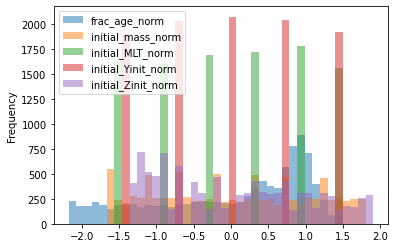

In [19]:
train.sample(n=10000).plot(kind='hist', y=[f'{col}_norm' for col in x_cols],
                           bins=40, alpha=0.5)

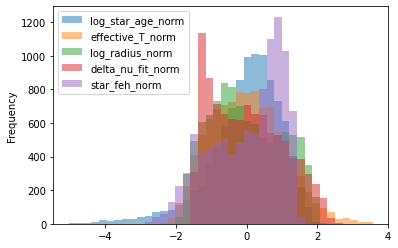

In [20]:
train.sample(n=10000).plot(kind='hist', y=[f'{col}_norm' for col in y_cols], bins=40, alpha=0.5)

Validation

In [21]:
val = pd.read_csv(f'{load_path}/{tracks}_val.csv')

In [22]:
t = Tracks()
t.set_data(val)

In [23]:
t.normalize(loc=factors['loc'].to_numpy(), scale=factors['scale'].to_numpy(),
            columns=x_cols+y_cols, inplace=True)

In [24]:
val = t.get_data([f'{col}_norm' for col in x_cols+y_cols])
val.head()

,frac_age_norm,initial_mass_norm,initial_MLT_norm,initial_Yinit_norm,initial_Zinit_norm,log_star_age_norm,effective_T_norm,log_radius_norm,delta_nu_fit_norm,star_feh_norm
0,-2.144928,0.02521,0.89645,-1.428571,-0.657099,-3.267303,0.389481,-1.339923,1.706118,-0.236674
1,-2.055016,0.02521,0.89645,-1.428571,-0.657099,-2.345807,0.403000,-1.312313,1.651492,-0.249146
2,-2.020283,0.02521,0.89645,-1.428571,-0.657099,-2.140266,0.408372,-1.302933,1.633083,-0.253994
3,-2.013346,0.02521,0.89645,-1.428571,-0.657099,-2.103994,0.409448,-1.301084,1.629465,-0.254954
4,-1.985631,0.02521,0.89645,-1.428571,-0.657099,-1.971340,0.413739,-1.293744,1.615137,-0.258766


In [25]:
del t

In [26]:
x_cols = [f'{col}_norm' for col in x_cols]
y_cols = [f'{col}_norm' for col in y_cols]

In [27]:
print(f'Length of training data = {len(train)}')
print(f'Length of validation data = {len(val)}')

Length of training data = 6000000
Length of validation data = 1933933


In [28]:
network = DenseNetwork.from_config(f'{save_path}/{name}_config.json')
network.load_model()
network.load_history()
network.model.summary()

Model: "network_07"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 5)]               0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)               1536      
_________________________________________________________________
dense_8 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_9 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_10 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_11 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_12 (Dense)             (None, 256)               6

In [ ]:
network.train(train, network.x_cols, network.y_cols, epochs=20000, validation_split=None, validation_data=val,
              callbacks=['checkpoint', 'tensorboard'])

In [ ]:
network.save()

In [ ]:
network.plot_metric(val.sample(20000), metric='absolute_error');

In [ ]:
network.plot_metric(val.sample(20000), metric='error');

In [ ]:
scores = network.scores(val.sample(20000))
scores

In [ ]:
scale_scores = factors.loc[5:, 'scale'].to_numpy() * scores

In [ ]:
log_cols = [col for col in scale_scores.columns if 'log' in col]
log_cols

scale_scores[[col[4:] for col in log_cols]] = scale_scores[log_cols] * np.log(10.0)

scale_scores.loc['std'].round(5)